In [64]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
import pickle as pkl
import seaborn as sns
from os.path import join as oj
import sklearn.model_selection
import sklearn.linear_model
import numpy.linalg as npl
import viz
from tqdm import tqdm
from scipy import optimize
import scipy.stats

PROCESSED_DIR = 'processed'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading

**load gt latents**

In [2]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))

**load annotations in different directions**

In [3]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
N = len(attrs)

In [40]:
attr_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in attrs]).transpose()
attr_mat = (attr_mat - attr_mat.mean(axis=0)) / attr_mat.std(axis=0)

In [41]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        latents, attr_mat, test_size=0.3, random_state=42)

In [42]:
n_train = X_train.shape[0]
latent_dim = X_train.shape[1]
n_attr = y_train.shape[1]
W = np.zeros((latent_dim, n_attr))

# fit with penalty

In [32]:
import torch 
  
class LinReg(torch.nn.Module): 
  
    def __init__(self, input_dim=512, output_dim=6): 
        super(LinReg, self).__init__() 
        self.linear = torch.nn.Linear(input_dim, output_dim)  # One in and one out 
  
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred

# setup
m = LinReg() 
X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
criterion = torch.nn.MSELoss(size_average=True) 
optimizer = torch.optim.SGD(m.parameters(), lr = 1e-1)
  
# fit
for epoch in range(10000): 
    y_pred = m(X_train_t)
    loss = criterion(y_pred, y_train_t) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item())) 

epoch 0, loss 1.0301775932312012
epoch 1000, loss 0.29791226983070374
epoch 2000, loss 0.2886766791343689
epoch 3000, loss 0.28578823804855347
epoch 4000, loss 0.284615695476532
epoch 5000, loss 0.2840746343135834
epoch 6000, loss 0.28380391001701355
epoch 7000, loss 0.28366005420684814
epoch 8000, loss 0.28358015418052673
epoch 9000, loss 0.2835340201854706


In [52]:
preds = m(torch.Tensor(X_test)).detach().numpy()

0.8064938644394782
0.5158236168658255
0.6470619503582727
0.8669435530593504
0.8838020907543686
0.7257414754002186


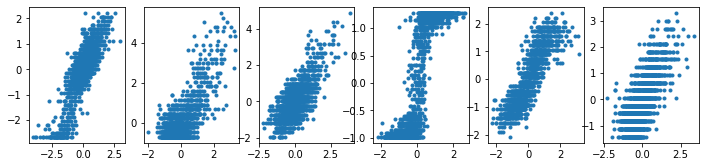

In [63]:
R, C = 1, 6
plt.figure(figsize=(12, 2.5))
for i in range(6):
    plt.subplot(R, C, i + 1)
    plt.plot(preds[:, i], y_test[:, i], '.')
    print(scipy.stats.spearmanr(preds[:, i], y_test[:, i]).correlation)
plt.show()

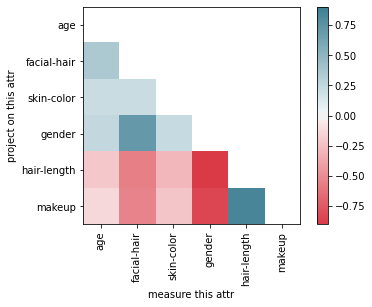

In [69]:
viz.corrplot(np.corrcoef(preds.transpose()))
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()